In [ ]:
import pandas as pd

from etl import *

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

In [2]:
DATA_DIR = './Data/'
DATA_FILE = 'spotify_tracks_kaggle_weekly.csv'
ARTIST_FILE = 'spotify_tracks_artist_details.csv'

In [3]:
data_tracks = pd.read_csv(DATA_DIR + DATA_FILE)
data_artist = pd.read_csv(DATA_DIR + ARTIST_FILE)
data = pd.merge(data_tracks, data_artist, on='track_id', how='left')
data = data[data.popularity > 0]

In [4]:
RANDOM_STATE = 21
TEST_SIZE = 0.1

In [5]:
data['popularity'] = (data['popularity'] >= 75).astype(int)
X = data.drop('popularity', axis=1)
y = data['popularity']

popularity
0    44313
1      301
Name: count, dtype: int64

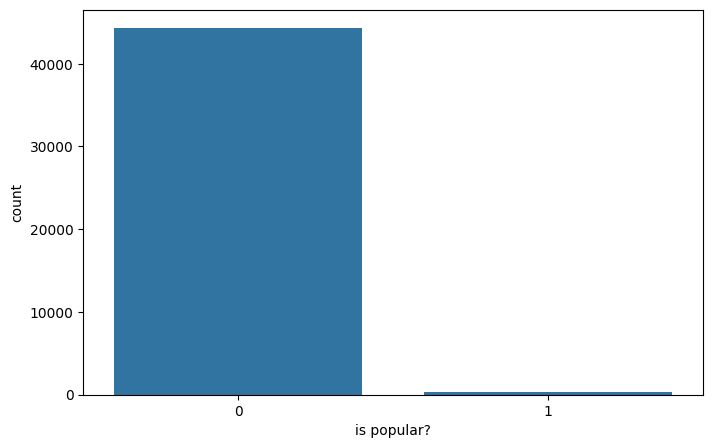

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.countplot(x='popularity', data=data)
plt.xlabel('is popular?')

y.value_counts()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [8]:
drop_columns = ['track_id', 'artwork_url', 'track_url', 'track_name']

In [9]:
X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

In [10]:
target = 'popularity'

onehot_col = ['language']
circle_of_fifths_col = ['key']
artist_name_col = ['artist_name']
album_name_col = ['album_name']

numeric_columns = list(X_train.columns[X_train.dtypes != object].difference(['key', 'mode']))

nan_columns = ['acousticness', 'danceability', 'energy', 'liveness', 'speechiness', 'tempo', 'valence']

In [11]:
numeric_pipeline = Pipeline(steps=[
    ('imputation', SimpleImputer()),
    ('polynomials', PolynomialFeatures()),
    ('scaling', StandardScaler())
])

artist_name_pipeline = Pipeline(steps=[
    ('encoding', FrequencyEncoder()),
    ('imputation', SimpleImputer()),
    ('scaling', StandardScaler())
])

album_name_pipeline = Pipeline(steps=[
    ('encoding', AlbumNameEncoder()),
    ('imputation', SimpleImputer())
])

circle_of_fifths_pipeline = Pipeline(steps=[
    ('encoding', CircleOfFifthsEncoding()),
    ('imputation', SimpleImputer())
])


transformations = ColumnTransformer(transformers=[
    
    ('onehot_encoding', OneHotEncoder(sparse_output=False), onehot_col),
    ('trigonometric_encoding', circle_of_fifths_pipeline, circle_of_fifths_col),
    ('artist_encoding', artist_name_pipeline, artist_name_col),
    ('album_encoding', album_name_pipeline, album_name_col),
    ('nummeric_processing', numeric_pipeline, numeric_columns)

], remainder='drop').set_output(transform='pandas')


preprocessing = Pipeline(steps=[
    
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations)

]).set_output(transform='pandas')

In [12]:
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

rf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classification', model)
])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('null_values',
                                  ConvertNull(columns=['acousticness',
                                                       'danceability', 'energy',
                                                       'liveness',
                                                       'speechiness', 'tempo',
                                                       'valence'])),
                                 ('transformation',
                                  ColumnTransformer(transformers=[('onehot_encoding',
                                                                   OneHotEncoder(sparse_output=False),
                                                                   ['language']),
                                                                  ('trigonometric_encoding',
                                                                   Pipeline(steps=[('encoding',
                                                                                    CircleOf...
                                                                                   ('polynomials',
                                                                                    PolynomialFeatures()),
                                                                                   ('scaling',
                                                                                    StandardScaler())]),
                                                                   ['acousticness',
                                                                    'artist_count',
                                                                    'avg_artist_popularity',
                                                                    'danceability',
                                                                    'duration_ms',
                                                                    'energy',
                                                                    'instrumentalness',
                                                                    'liveness',
                                                                    'loudness',
                                                                    'speechiness',
                                                                    'tempo',
                                                                    'time_signature',
                                                                    'valence',
                                                                    'year'])]))])),
                ('classification',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=21))])

Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4432
           1       0.00      0.00      0.00        30

    accuracy                           0.99      4462
   macro avg       0.50      0.50      0.50      4462
weighted avg       0.99      0.99      0.99      4462

Random Forest ROC AUC Score: 0.7638086642599278
Confusion matrix
[[4420   12]
 [  30    0]]
F1 score 0.0


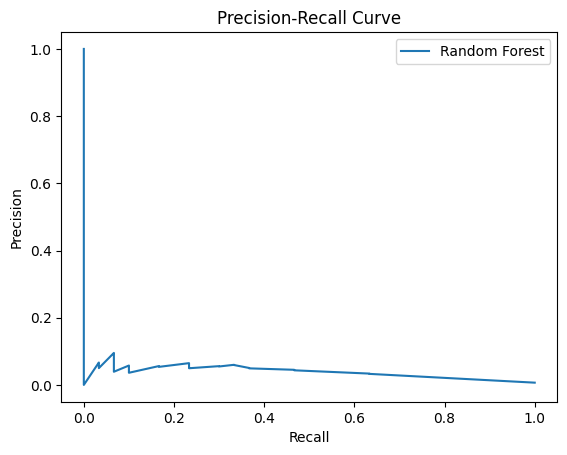

In [13]:
y_pred = rf_pipeline.predict(X_test)
y_pred_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print('Classification report')
print(classification_report(y_test, y_pred))
print('Random Forest ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [14]:
smote_pipeline = ImbPipeline(steps=[
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations),
    ('oversampling', SMOTE(random_state=RANDOM_STATE)),
    ('classification', model)
])

smote_pipeline.fit(X_train, y_train)

Pipeline(steps=[('null_values',
                 ConvertNull(columns=['acousticness', 'danceability', 'energy',
                                      'liveness', 'speechiness', 'tempo',
                                      'valence'])),
                ('transformation',
                 ColumnTransformer(transformers=[('onehot_encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['language']),
                                                 ('trigonometric_encoding',
                                                  Pipeline(steps=[('encoding',
                                                                   CircleOfFifthsEncoding()),
                                                                  ('imputation',
                                                                   S...
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['acousticness',
                                                   'artist_count',
                                                   'avg_artist_popularity',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'time_signature', 'valence',
                                                   'year'])])),
                ('oversampling', SMOTE(random_state=21)),
                ('classification',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=21))])

Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4432
           1       0.08      0.07      0.07        30

    accuracy                           0.99      4462
   macro avg       0.54      0.53      0.53      4462
weighted avg       0.99      0.99      0.99      4462

Random Forest with SMOTE ROC AUC Score: 0.8574984957882069
Confusion matrix
[[4410   22]
 [  28    2]]
F1 score 0.07407407407407407


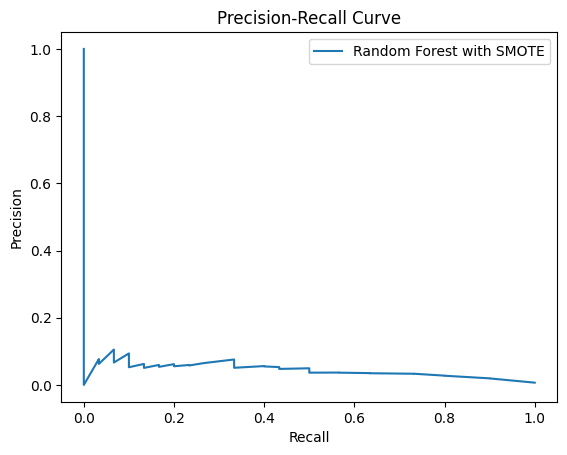

In [ ]:
y_pred = smote_pipeline.predict(X_test)
y_pred_proba = smote_pipeline.predict_proba(X_test)[:, 1]

print('Classification report')
print(classification_report(y_test, y_pred))
print('Random Forest with SMOTE ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label='Random Forest with SMOTE', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [30]:
lgbm_model = LGBMClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=RANDOM_STATE
)

lgbm_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classification', lgbm_model)
])

lgbm_pipeline.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 271, number of negative: 39881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28757
[LightGBM] [Info] Number of data points in the train set: 40152, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006749 -> initscore=-4.991536
[LightGBM] [Info] Start training from score -4.991536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('null_values',
                                  ConvertNull(columns=['acousticness',
                                                       'danceability', 'energy',
                                                       'liveness',
                                                       'speechiness', 'tempo',
                                                       'valence'])),
                                 ('transformation',
                                  ColumnTransformer(transformers=[('onehot_encoding',
                                                                   OneHotEncoder(sparse_output=False),
                                                                   ['language']),
                                                                  ('trigonometric_encoding',
                                                                   Pipeline(steps=[('encoding',
                                                                                    CircleOf...
                                                                                   ('polynomials',
                                                                                    PolynomialFeatures()),
                                                                                   ('scaling',
                                                                                    StandardScaler())]),
                                                                   ['acousticness',
                                                                    'artist_count',
                                                                    'avg_artist_popularity',
                                                                    'danceability',
                                                                    'duration_ms',
                                                                    'energy',
                                                                    'instrumentalness',
                                                                    'liveness',
                                                                    'loudness',
                                                                    'speechiness',
                                                                    'tempo',
                                                                    'time_signature',
                                                                    'valence',
                                                                    'year'])]))])),
                ('classification',
                 LGBMClassifier(random_state=21,
                                scale_pos_weight=147.16236162361625))])

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78      4432
           1       0.01      0.80      0.03        30

    accuracy                           0.64      4462
   macro avg       0.51      0.72      0.40      4462
weighted avg       0.99      0.64      0.77      4462

LightGBM ROC AUC Score: 0.7291629061371843
Confusion matrix
[[2825 1607]
 [   6   24]]
F1 score 0.028898254063816978


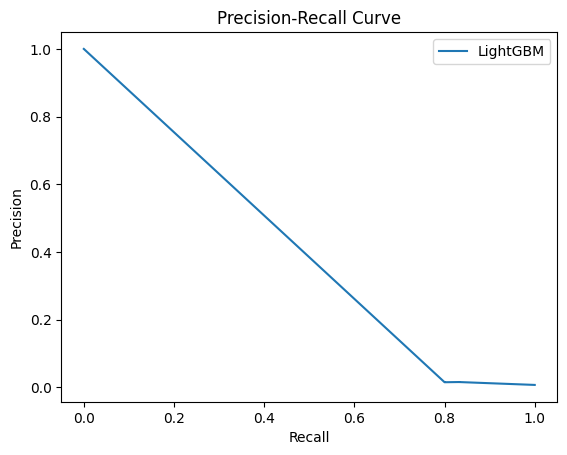

In [31]:
y_pred_lgbm = lgbm_pipeline.predict(X_test)
y_pred_proba_lgbm = lgbm_pipeline.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))
print("LightGBM ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_lgbm))
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred_lgbm))
print('F1 score', f1_score(y_test, y_pred_lgbm))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)
plt.plot(recall, precision, label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [38]:
lgbm_model = LGBMClassifier(
    random_state=RANDOM_STATE,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
)

lgbm_pipeline = ImbPipeline(steps=[
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations),
    ('oversampling', SMOTE(random_state=RANDOM_STATE)),
    ('classification', lgbm_model)
])

lgbm_pipeline.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 39881, number of negative: 39881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 79762, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('null_values',
                 ConvertNull(columns=['acousticness', 'danceability', 'energy',
                                      'liveness', 'speechiness', 'tempo',
                                      'valence'])),
                ('transformation',
                 ColumnTransformer(transformers=[('onehot_encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['language']),
                                                 ('trigonometric_encoding',
                                                  Pipeline(steps=[('encoding',
                                                                   CircleOfFifthsEncoding()),
                                                                  ('imputation',
                                                                   S...
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['acousticness',
                                                   'artist_count',
                                                   'avg_artist_popularity',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'time_signature', 'valence',
                                                   'year'])])),
                ('oversampling', SMOTE(random_state=21)),
                ('classification',
                 LGBMClassifier(random_state=21,
                                scale_pos_weight=147.16236162361625))])

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4432
           1       0.07      0.47      0.12        30

    accuracy                           0.95      4462
   macro avg       0.53      0.71      0.55      4462
weighted avg       0.99      0.95      0.97      4462

LightGBM with SMOTE ROC AUC Score: 0.9050992779783393
Confusion matrix
[[4245  187]
 [  16   14]]
F1 score 0.12121212121212122


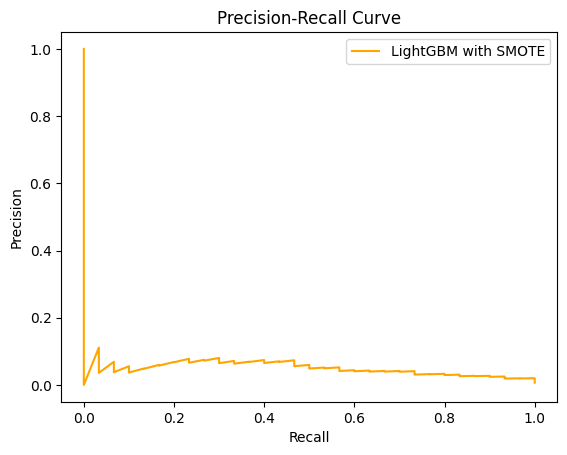

In [33]:
y_pred_lgbm = lgbm_pipeline.predict(X_test)
y_pred_proba_lgbm = lgbm_pipeline.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))
print("LightGBM with SMOTE ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_lgbm))
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred_lgbm))
print('F1 score', f1_score(y_test, y_pred_lgbm))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)
plt.plot(recall, precision, label='LightGBM with SMOTE', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [20]:
model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classification', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('null_values',
                                  ConvertNull(columns=['acousticness',
                                                       'danceability', 'energy',
                                                       'liveness',
                                                       'speechiness', 'tempo',
                                                       'valence'])),
                                 ('transformation',
                                  ColumnTransformer(transformers=[('onehot_encoding',
                                                                   OneHotEncoder(sparse_output=False),
                                                                   ['language']),
                                                                  ('trigonometric_encoding',
                                                                   Pipeline(steps=[('encoding',
                                                                                    CircleOf...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=21, ...))])

Classification report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4432
           1       0.03      0.03      0.03        30

    accuracy                           0.99      4462
   macro avg       0.51      0.51      0.51      4462
weighted avg       0.99      0.99      0.99      4462

XGBoost ROC AUC Score: 0.9167193140794223
Confusion matrix
[[4401   31]
 [  29    1]]
F1 score 0.03225806451612903


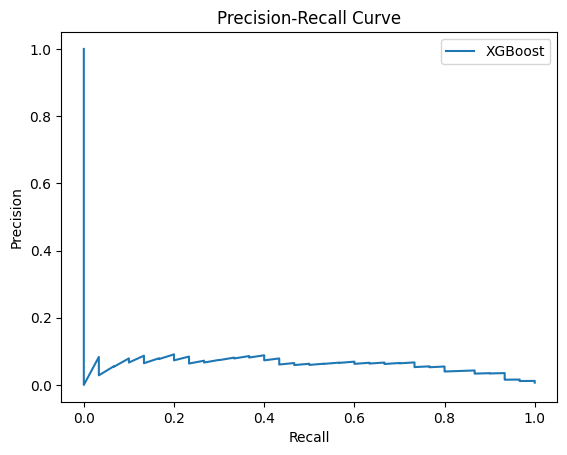

In [21]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

print('Classification report')
print(classification_report(y_test, y_pred))
print('XGBoost ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [34]:
model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

pipeline = ImbPipeline(steps=[
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations),
    ('oversampling', SMOTE(random_state=RANDOM_STATE)),
    ('classification', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('null_values',
                 ConvertNull(columns=['acousticness', 'danceability', 'energy',
                                      'liveness', 'speechiness', 'tempo',
                                      'valence'])),
                ('transformation',
                 ColumnTransformer(transformers=[('onehot_encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['language']),
                                                 ('trigonometric_encoding',
                                                  Pipeline(steps=[('encoding',
                                                                   CircleOfFifthsEncoding()),
                                                                  ('imputation',
                                                                   S...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=21, ...))])

Classification report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4432
           1       0.07      0.13      0.09        30

    accuracy                           0.98      4462
   macro avg       0.53      0.56      0.54      4462
weighted avg       0.99      0.98      0.98      4462

XGBoost with SMOTE ROC AUC Score: 0.8945848375451264
Confusion matrix
[[4377   55]
 [  26    4]]
F1 score 0.0898876404494382


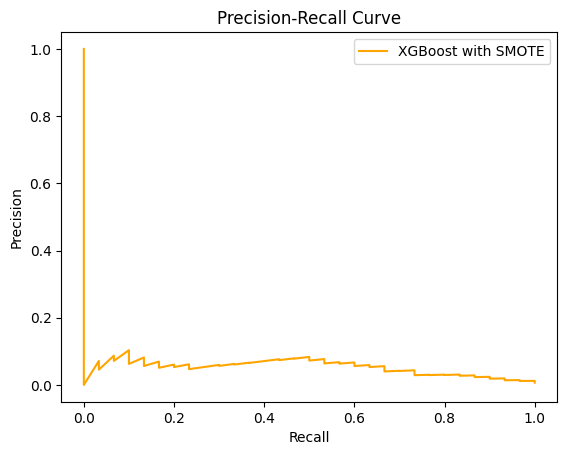

In [35]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

print('Classification report')
print(classification_report(y_test, y_pred))
print('XGBoost with SMOTE ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label='XGBoost with SMOTE', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [37]:
param_grid = {
    'classification__n_estimators': [50, 100, 200, 500],
    'classification__learning_rate': np.logspace(-3, 0, 10),
    'classification__max_depth': [3, 5, 7, 10, -1],
    'classification__num_leaves': [31, 63, 127, 255],
    'classification__min_child_samples': [5, 10, 20, 50],
    'classification__subsample': np.linspace(0.2, 1.0, 9),
    'classification__colsample_bytree': np.linspace(0.2, 1.0, 9),
    'classification__scale_pos_weight': [len(y_train[y_train == 0]) / len(y_train[y_train == 1])],
}

In [40]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid,
    n_iter=60,
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation F1 Score:", random_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 39881, number of negative: 39881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 79762, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4432
           1       0.07      0.30      0.11        30

    accuracy                           0.97      4462
   macro avg       0.53      0.64      0.55      4462
weighted avg       0.99      0.97      0.98      4462

Optimized LightGBM with SMOTE ROC AUC Score: 0.9125225631768953
Confusion matrix
[[4308  124]
 [  21    9]]
F1 score 0.11042944785276074


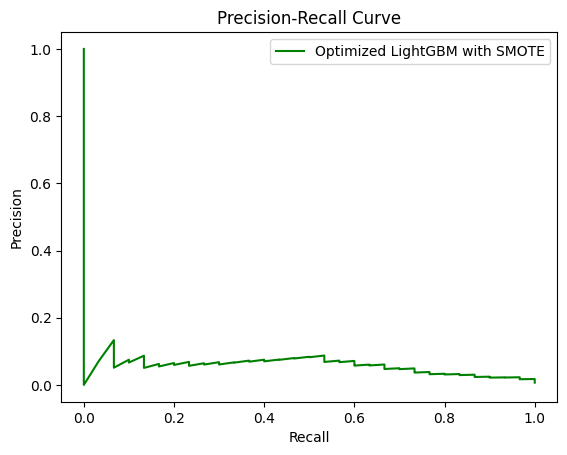

In [41]:
best_pipeline = random_search.best_estimator_

y_pred_lgbm = best_pipeline.predict(X_test)
y_pred_proba_lgbm = best_pipeline.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))
print("Optimized LightGBM with SMOTE ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_lgbm))
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred_lgbm))
print('F1 score', f1_score(y_test, y_pred_lgbm))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)
plt.plot(recall, precision, label='Optimized LightGBM with SMOTE', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()